In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import os

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
root_dir = r"D:\00 Safi\Land Cover\Data\01 UCMerced_LandUse\Images"  # Change this to your dataset path
dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet model
num_classes = 21  # Update based on your dataset
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\IMlab\anaconda3\envs\lab\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\IMlab\anaconda3\envs\lab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Training the model
epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []


def train():
    model.train()
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss/total, acc=100*correct/total)
        train_losses.append(running_loss/len(train_loader))
        train_accuracies.append(100 * correct / total)
        validate()

def validate():
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_losses.append(running_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    model.train()

# Run training
train()

Epoch [10/10]: 100%|██████████| 53/53 [00:06<00:00,  8.47it/s, acc=97.3, loss=0.0028] 


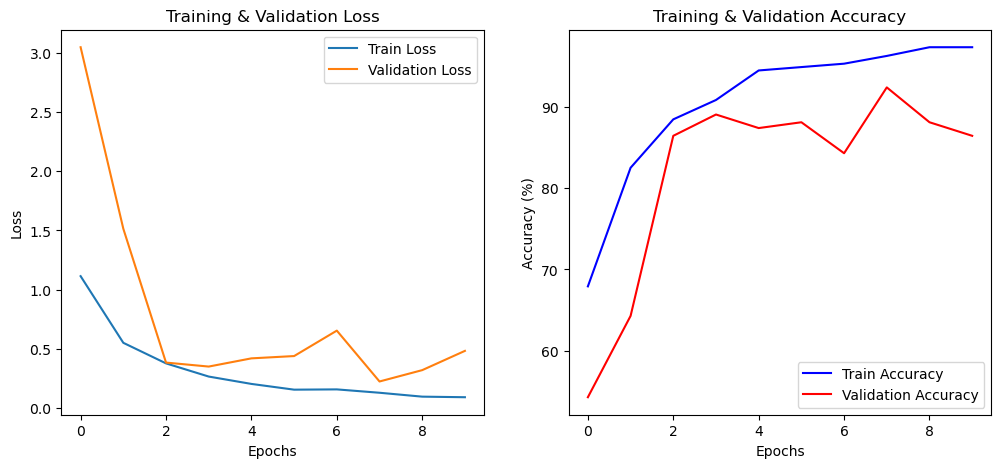

Validation Accuracy: 86.43%


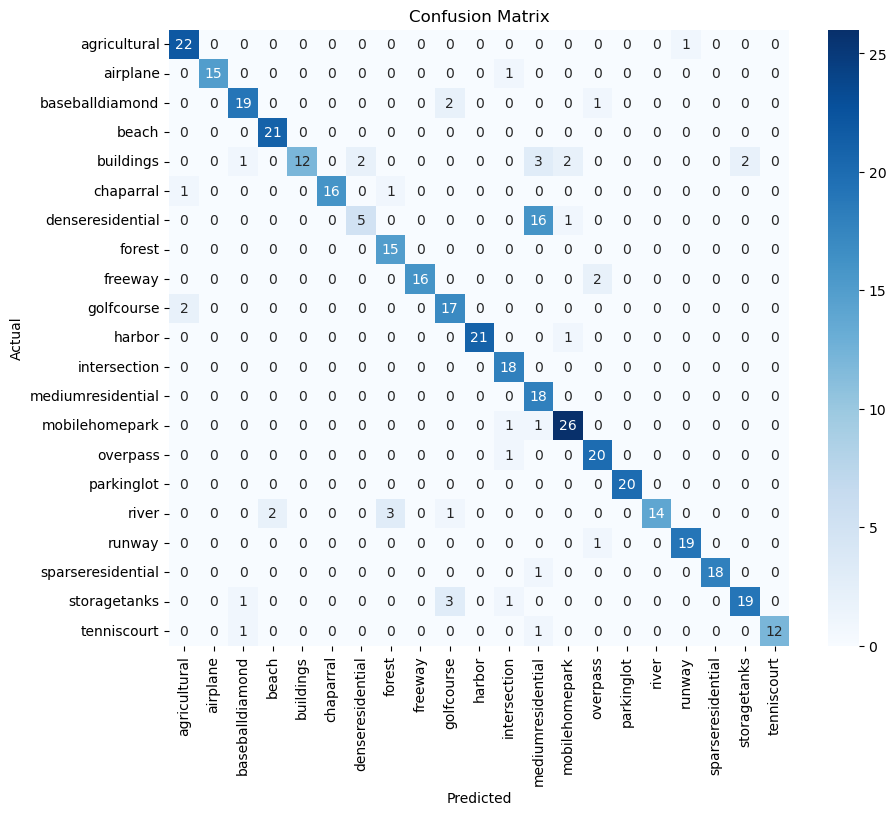

In [14]:
# Plot Accuracy and Loss
def plot_metrics():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.show()

plot_metrics()

# Evaluate the model
def evaluate():
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    print(f"Validation Accuracy: {acc * 100:.2f}%")
    return y_true, y_pred

y_true, y_pred = evaluate()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


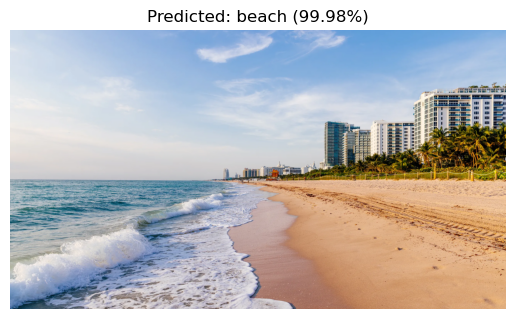

Predicted class: beach with probability 99.98%


In [18]:
# Prediction function
def predict(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()
    plt.title(f"Predicted: {dataset.classes[predicted_class]} ({probabilities[predicted_class]*100:.2f}%)")
    plt.show()
    print(f"Predicted class: {dataset.classes[predicted_class]} with probability {probabilities[predicted_class]*100:.2f}%")

# Example usage
predict(r"D:\00 Safi\Land Cover\Data\01 UCMerced_LandUse\Bark-Beach-miami_GettyImages-1540357059.webp")  # Change this to your image path